In [1]:
import numpy as np
#import generative_model, generative_model_global, classifier_pool, tools
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [75]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys; sys.path.insert(0, '../discrepancies-in-machine-learning')
from discrepancies import datasets, pool


dataset_name="adult-cat"
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset=dataset_name, test_size=0.3)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

"""data = fetch_openml(data_id=853, return_X_y=False) #BOSTON
#data = fetch_openml(data_id=1590, return_X_y=False) #ADULT
X = data.data.astype('float')
y = data.target
y = (y=='P').astype('int') #BOSTON"""
#X, y = make_moons(1000, noise=0.5)
#X = pd.DataFrame(X)
#X = (X - X.mean()) / X.std()
#feature_names = data.feature_names
#target_names = data.target_names

#y = np.array(y).reshape(-1, 1) # fixed an error..
#(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.4, stratify=y, random_state=1)


# numpy to pytorch stuff
dataset_train = TensorDataset(torch.Tensor(X_train.values),torch.Tensor(y_train))
dataset_test = TensorDataset(torch.Tensor(X_test.values),torch.Tensor(y_test))
train_loader = DataLoader(dataset_train, batch_size=3000, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset_test, batch_size=3000, shuffle=True, drop_last=False)

taking only 3000 instances


In [76]:
X_train.shape

(2100, 96)

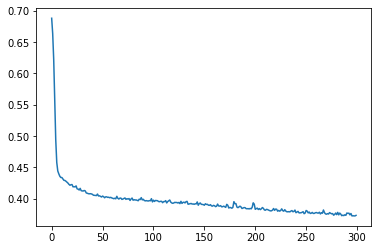

In [3]:

class clf1(nn.Module):
    
    def __init__(self):
        super(clf1, self).__init__()
        
        self.fc1 = nn.Linear(X.shape[1], 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = torch.sigmoid(self.fc4(h3))
        return h4


modelf = clf1()
criterion = nn.BCELoss(reduction='sum')
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(modelf.parameters())

N_EPOCHS = 300



def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):#tqdm(, total=int(X_train.shape[0]/dataloader.batch_size)):
        x, y = data
        p_y = model(x)
        optimizer.zero_grad()
        loss = criterion(p_y, y)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss



train_loss = []
for epoch in range(N_EPOCHS):
    #print(f"Epoch {epoch+1} of {N_EPOCHS}")
    train_epoch_loss = fit(modelf, train_loader)
    #val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)


def accuracy_AUC(model, dataloader):
    running_loss = 0.0
    probs = []
    yall = []
    for x, y in dataloader:
        p_y = model(x)
        probs.extend(p_y.detach().numpy())
        yall.extend(y.detach().numpy())
    return metrics.roc_auc_score(yall, probs)


def accuracy_score(model, dataloader):
    running_loss = 0.0
    probs = []
    yall = []
    for x, y in dataloader:
        p_y = model(x)
        probs.extend((p_y.detach() >= 0.5).int().numpy())
        yall.extend(y.detach().numpy())
    return metrics.accuracy_score(yall, probs)



def accuracy_f1(model, dataloader):
    running_loss = 0.0
    probs = []
    yall = []
    for x, y in dataloader:
        p_y = model(x)
        probs.extend((p_y.detach() >= 0.5).int().numpy())
        yall.extend(y.detach().numpy())
    return metrics.f1_score(yall, probs)



In [4]:
from sklearn import metrics 
accuracy_score(modelf, test_loader), accuracy_AUC(modelf, test_loader), accuracy_f1(modelf, test_loader)

NameError: name 'accuracy_score' is not defined

In [5]:



class disc_clf(nn.Module):
    
    def __init__(self):
        super(disc_clf, self).__init__()
        
        self.fc1 = nn.Linear(X.shape[1], 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc21 = nn.Linear(32, 64)
        self.fc22 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h21 = torch.relu(self.fc21(h2))
        h22 = torch.relu(self.fc22(h21))
        h3 = torch.relu(self.fc3(h22))
        h4 = torch.sigmoid(self.fc4(h3))
        return h4



def disc_fit(model, model1, dataloader, criterion, optimizer, lambda_=1.0):
    model.train()
    running_loss = 0.0
    running_pred_loss = 0.0
    running_disc_loss = 0.0
    for i, data in enumerate(dataloader):#tqdm(, total=int(X_train.shape[0]/dataloader.batch_size)):
        x, y = data
        p_y = model(x)
        p_y_model1 = model1(x).detach()
        
        optimizer.zero_grad()
        
        pred_loss = criterion(p_y, y)
        pred_y_model1 = (p_y_model1 >= 0.5).int()
        pred_y = (p_y >= 0.5).int()
        
        disc_loss = criterion(p_y, pred_y_model1.float())

            
        loss = pred_loss - lambda_ * disc_loss
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
        running_pred_loss += pred_loss.item()
        running_disc_loss += disc_loss.item()
        
    train_loss = running_loss/len(dataloader.dataset)
    train_pred_loss = running_pred_loss/len(dataloader.dataset)
    train_disc_loss = running_disc_loss/len(dataloader.dataset)
    return train_loss, train_pred_loss, train_disc_loss

def train_discrepancy(lambda_, disc_model, model1, criterion, optimizer, plot=True):
    
    train_loss = []
    train_pred_loss = []
    train_disc_loss = []
    for epoch in range(N_EPOCHS):
        #print(f"Epoch {epoch+1} of {N_EPOCHS}")
        train_epoch_loss, tpl, tdl = disc_fit(disc_model, model1, train_loader, criterion, optimizer, lambda_)
        train_loss.append(train_epoch_loss)
        train_pred_loss.append(tpl)
        train_disc_loss.append(tdl)
    if plot==True:
        plt.plot(train_loss)
        plt.plot(train_pred_loss)
        plt.plot(train_disc_loss)
        plt.show()



def discrepancy(model1, model2, dataloader):
    running_loss = 0.0
    disag = 0
    for x, _ in dataloader:
        p_y = (model1(x).detach() >= 0.5).int()
        pf_y = (model2(x).detach() >= 0.5).int()
        disag +=  (p_y != pf_y).sum()
        
    return disag / len(dataloader.dataset)
        


0.0
0.1
0.2
0.3
Accuracy of original model 0.8125
CPU times: user 2min 6s, sys: 1.2 s, total: 2min 7s
Wall time: 2min 7s


<AxesSubplot:xlabel='disc_score', ylabel='AUC'>

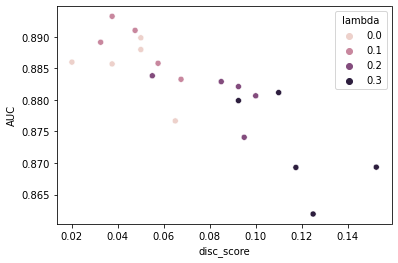

In [25]:
%%time

LAMBDAS = [l/10.0 for l in range(0, 4, 1)]


acc_score_adv, f1_score_adv, auc_score_adv, disc_score = [], [], [], []
iteration, lambdas_ = [], []
data_loader = test_loader
for lambda_ in LAMBDAS:
    print(lambda_)
    for it in range(5):
        disc_model = disc_clf()
        criterion2 = nn.BCELoss(reduction='sum')
        optimizer2 = optim.Adam(disc_model.parameters(), lr=0.001)
        N_EPOCHS = 300
        train_discrepancy(lambda_, disc_model, modelf, criterion2, optimizer2, plot=False)
        acc_score_adv.append(accuracy_score(disc_model, data_loader))
        auc_score_adv.append(accuracy_AUC(disc_model, data_loader))
        f1_score_adv.append(accuracy_f1(disc_model, data_loader))
        disc_score.append(discrepancy(modelf, disc_model, data_loader))
        #iteration.append(it)
        lambdas_.append(lambda_)

df_results = pd.DataFrame(lambdas_, columns = ["lambda"])
df_results["AUC"] = auc_score_adv
df_results["accuracy"] = acc_score_adv
df_results["F1"] = f1_score_adv
df_results["disc_score"] = disc_score
#df_results["iteration"] = iteration


print('Accuracy of original model', accuracy_score(modelf, test_loader))
sns.scatterplot(data=df_results, x="disc_score", y="AUC", hue="lambda")

In [26]:
import sys; sys.path.insert(0, '../discrepancies-in-machine-learning')
from discrepancies import datasets, pool

pool1 = pool.BasicPool(models=['SVMrbf', 'RF100', 'RF200'])
print(pool1._model_types)
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
disc_pool = pool1.predict_discrepancies(X_test).mean()
f1_pool = np.array([metrics.f1_score(y_test, preds[c]) for c in preds.columns]).min()
acc_pool = np.array([metrics.accuracy_score(y_test, preds[c]) for c in preds.columns]).min()
#f1_pool = np.array([metrics.f1_score(y_test, preds[c]) for c in preds.columns]).mean()
#print('=== ACCURACIES', {c: f1_score(y_test, preds[c]) for c in preds.columns})
#print('=== CONFLICTING PREDICTIONS', pool1.predict_discrepancies(X_test).mean())

['SVMrbf', 'RF100', 'RF200']


/Users/b076rg/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/b076rg/Documents/research/articles/discrepancy/discrepancies-generative/../discrepancies-in-machine-learning/discrepancies/pool.py:101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
/Users/b076rg/Documents/research/articles/discrepancy/discrepancies-generative/../discrepancies-in-machine-learning/discrepancies/pool.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)


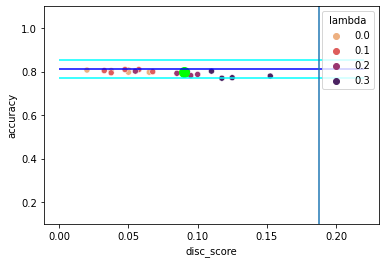

In [30]:
sns.scatterplot(data=df_results, x="disc_score", y="accuracy", hue="lambda", palette="flare")
plt.hlines(y=accuracy_score(modelf, test_loader), xmin=0.0, xmax=0.22, color="blue")
plt.hlines(y=accuracy_score(modelf, test_loader)*1.05, xmin=0.0, xmax=0.22, color="cyan")
plt.hlines(y=accuracy_score(modelf, test_loader)*0.95, xmin=0.0, xmax=0.22, color="cyan")
plt.vlines(x=1 - accuracy_score(modelf, test_loader), ymin=0.1, ymax=1.1)

plt.scatter(x=disc_pool, y=acc_pool, color='lime', s=100)
plt.ylim((0.1, 1.1))
plt.show()

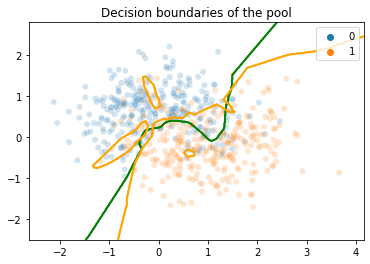

In [38]:

def plot_contour_pool(pool_, data, data_y):
    # Plotting decision regions #bricolage
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                      np.arange(y_min, y_max, 0.01))
    colors_ = ['green', 'orange', 'red', 'blue', 'purple', 'yellow', 'pink', 'cyan', 'black', 'grey', 'lime']
    i = 0
    sns.scatterplot(x=data[:,0], y=data[:, 1], hue=data_y.reshape(int(data.shape[0])), alpha=0.2)
    for clf in pool_:
        Z = clf(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
        Z = (Z.detach() >= 0.5).int().numpy().reshape(xx.shape)
        plt.contour(xx, yy, Z, alpha=0.5, colors=colors_[i])
        i += 1
    plt.title('Decision boundaries of the pool')
    plt.show()
    
plot_contour_pool(pool_=[modelf, disc_model], data=torch.from_numpy(X_train.values), data_y=y_train)

/Users/b076rg/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/b076rg/Documents/research/articles/discrepancy/discrepancies-generative/../discrepancies-in-machine-learning/discrepancies/pool.py:101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
/Users/b076rg/Documents/research/articles/discrepancy/discrepancies-generative/../discrepancies-in-machine-learning/discrepancies/pool.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)


# co training

In [78]:



class DiscAdv(nn.Module):
    
    def __init__(self):
        super(DiscAdv, self).__init__()
        
        self.fcf1 = nn.Linear(X_train.shape[1], 16)
        self.fcf2 = nn.Linear(16, 32)
        self.fcf3 = nn.Linear(32, 64)
        self.fcf4 = nn.Linear(64, 32)
        self.fcf5 = nn.Linear(32, 16)
        self.fcf6 = nn.Linear(16, 1)
        
        self.fcg1 = nn.Linear(X_train.shape[1], 16)
        self.fcg2 = nn.Linear(16, 32)
        self.fcg3 = nn.Linear(32, 64)
        self.fcg4 = nn.Linear(64, 32)
        self.fcg5 = nn.Linear(32, 16)
        self.fcg6 = nn.Linear(16, 1)
        
    def forward_f(self, x):
        h1 = torch.relu(self.fcf1(x))
        h2 = torch.relu(self.fcf2(h1))
        h3 = torch.relu(self.fcf3(h2))
        h4 = torch.relu(self.fcf4(h3))
        h5 = torch.relu(self.fcf5(h4))
        h6 = torch.sigmoid(self.fcf6(h5))
        return h6
    
    def forward_g(self, x):
        h1 = torch.relu(self.fcg1(x))
        h2 = torch.relu(self.fcg2(h1))
        h3 = torch.relu(self.fcg3(h2))
        h4 = torch.relu(self.fcg4(h3))
        h5 = torch.relu(self.fcf5(h4))
        h6 = torch.sigmoid(self.fcf6(h5))
        return h6
    
    def forward(self, x):
        return self.forward_f(x), self.forward_g(x)


def disc_fit(model, dataloader, criterionf, criteriong, criterion_disc, optimizer, lambda_=1.0):
    model.train()
    running_loss = 0.0
    running_pred_f_loss = 0.0
    running_pred_g_loss = 0.0
    running_disc_loss = 0.0
    
    for x, y in dataloader:
        
        optimizer.zero_grad()
        
        pf_y, pg_y = model(x)
        
        predf_loss = criterionf(pf_y, y)
        predg_loss = criteriong(pg_y, y)        
        disc_loss = criterion_disc(pf_y, pg_y) # on cherche à maximiser la différence entre les probas
        ###2e facon: on utilise bce sur classe de f, proba de g
        #predf_y = (pf_y >= 0.5).int().float()
        #disc_loss = criterion(pg_y, predf_y)
        
            
        loss = predf_loss + predg_loss - lambda_ * disc_loss
        
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
        running_pred_f_loss += predf_loss.item()
        running_pred_g_loss += predg_loss.item()
        running_disc_loss += disc_loss.item()
        
    train_loss = running_loss/len(dataloader.dataset)
    train_predf_loss = running_pred_f_loss/len(dataloader.dataset)
    train_predg_loss = running_pred_g_loss/len(dataloader.dataset)
    train_disc_loss = running_disc_loss/len(dataloader.dataset)
    return train_loss, train_predf_loss, train_predg_loss, train_disc_loss



def train_discrepancy(lambda_, model, criterion1, criterion2, criterion_disc, optimizer, plot=True):
    
    train_loss = []
    train_predf_loss = []
    train_predg_loss = []
    train_disc_loss = []
    
    for epoch in range(N_EPOCHS):
        #print(f"Epoch {epoch+1} of {N_EPOCHS}")
        train_epoch_loss, tpfl, tpgl, tdl = disc_fit(model, train_loader, criterion1, criterion2, criterion_disc, optimizer, lambda_)
        train_loss.append(train_epoch_loss)
        train_predf_loss.append(tpfl)
        train_predg_loss.append(tpgl)
        train_disc_loss.append(tdl)
        
    if plot==True:
        plt.plot(train_loss)
        plt.show()
        plt.plot(train_predf_loss)
        plt.plot(train_predg_loss)
        plt.plot(train_disc_loss)
        plt.show()


def discrepancy(model, dataloader):
    running_loss = 0.0
    disag = 0
    for x, _ in dataloader:
        pf_y, pg_y = model(x)
        
        fy = (pf_y.detach() >= 0.5).int()
        gy = (pg_y.detach() >= 0.5).int()
        disag +=  (fy != gy).sum().item()
        
    return disag / len(dataloader.dataset)
        


def accuracy_AUC2(model, dataloader):
    probsf = []
    probsg = []
    yall = []
    for x, y in dataloader:
        pf_y, pg_y = model(x)
        probsf.extend(pf_y.detach().numpy())
        probsg.extend(pg_y.detach().numpy())
        yall.extend(y.detach().numpy())
    return metrics.roc_auc_score(yall, probsf), metrics.roc_auc_score(yall, probsg)


def accuracy_score2(model, dataloader):
    probsf = []
    probsg = []
    yall = []
    for x, y in dataloader:
        pf_y, pg_y = model(x)
        probsf.extend((pf_y.detach() >= 0.5).int().numpy())
        probsg.extend((pg_y.detach() >= 0.5).int().numpy())
        yall.extend(y.detach().numpy())
    return metrics.accuracy_score(yall, probsf), metrics.accuracy_score(yall, probsg)


def accuracy_f12(model, dataloader):
    probsf = []
    probsg = []
    yall = []
    for x, y in dataloader:
        pf_y, pg_y = model(x)
        probsf.extend((pf_y.detach() >= 0.5).int().numpy())
        probsg.extend((pg_y.detach() >= 0.5).int().numpy())
        yall.extend(y.detach().numpy())
    return metrics.f1_score(yall, probsf), metrics.f1_score(yall, probsg)



0.0


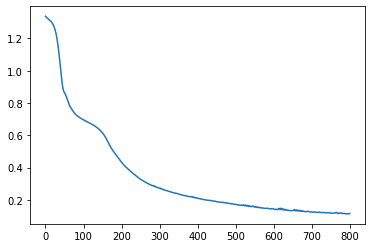

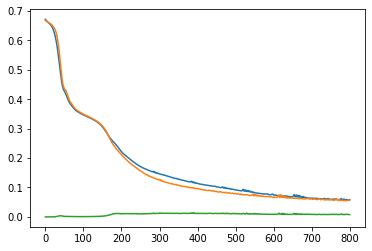

0.1


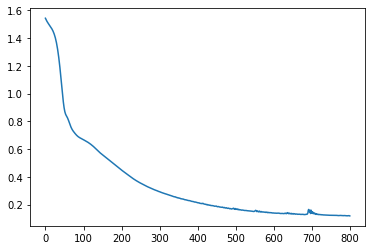

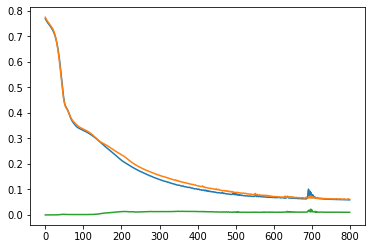

0.2


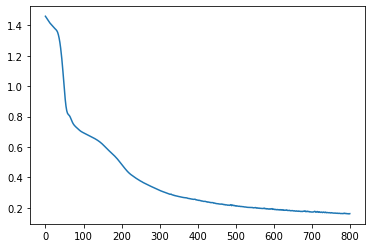

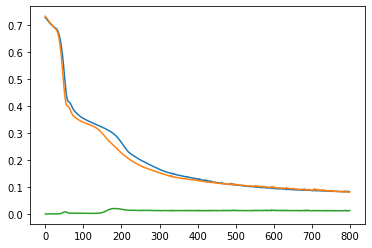

0.3


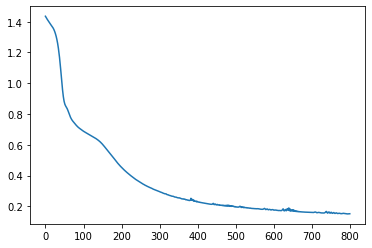

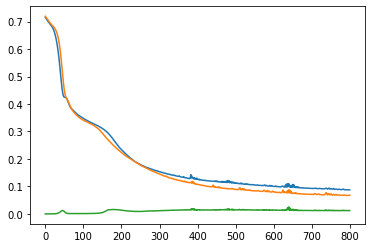

0.4


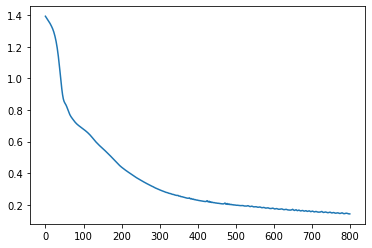

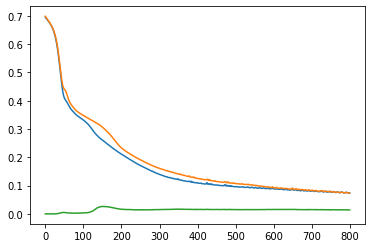

0.5


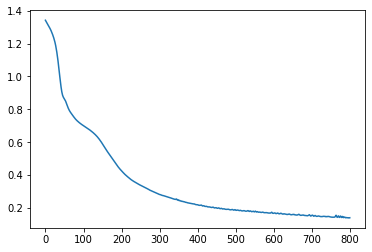

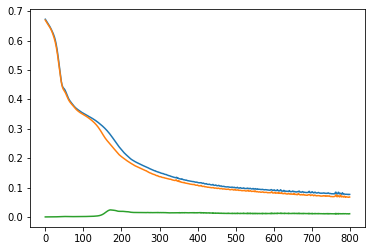

0.6


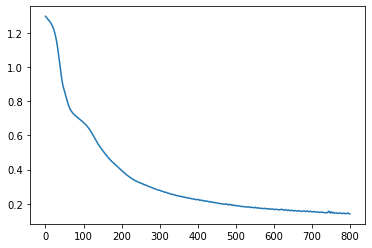

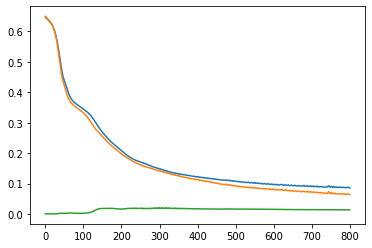

0.7


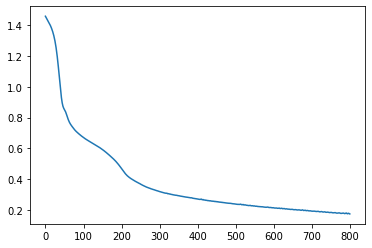

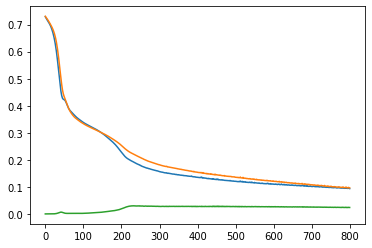

0.8


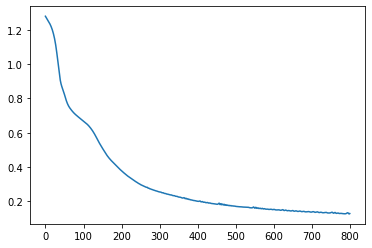

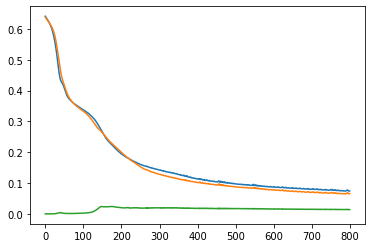

0.9


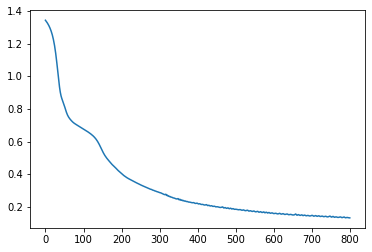

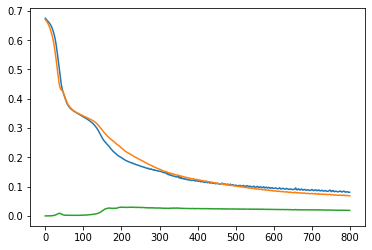

1.0


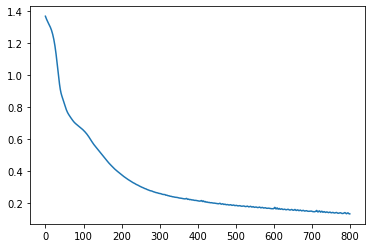

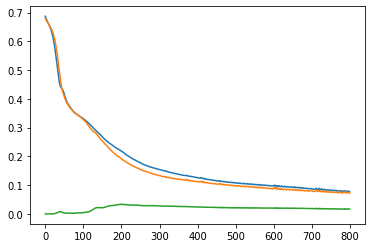

1.1


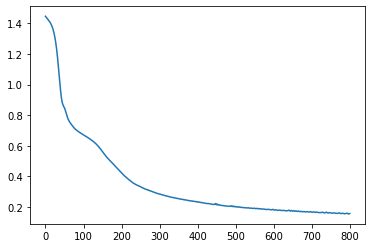

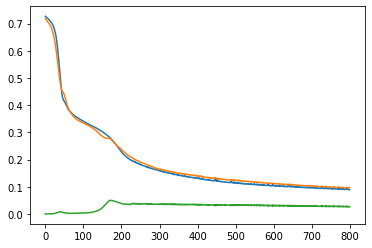

1.2


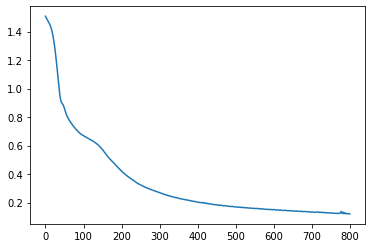

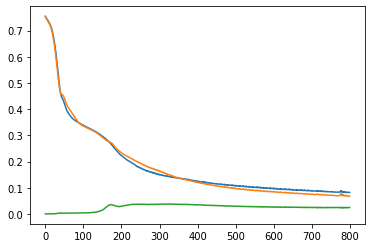

1.3


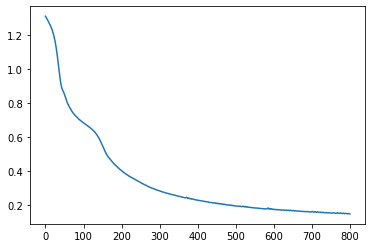

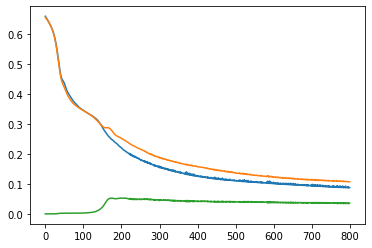

1.4


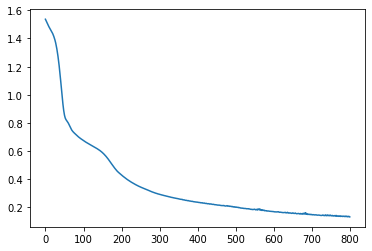

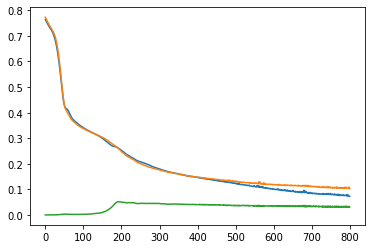

1.5


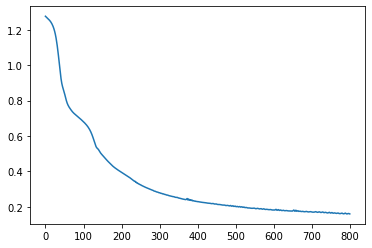

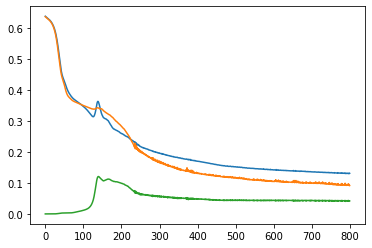

1.6


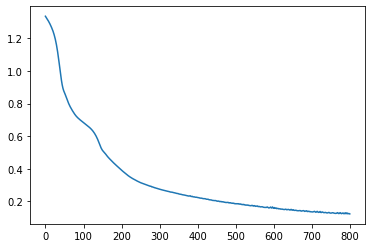

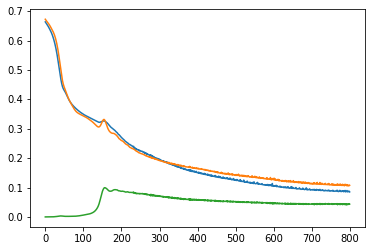

1.7


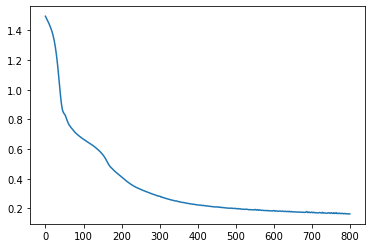

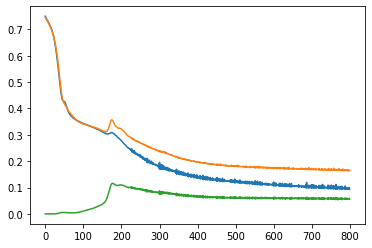

1.8


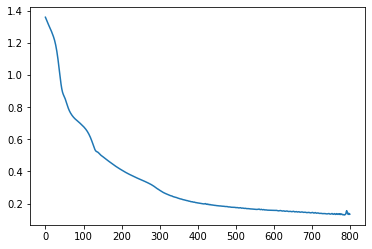

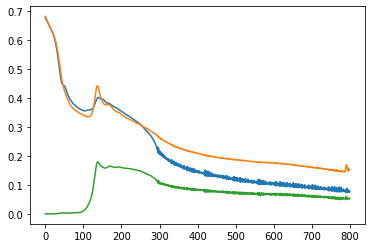

1.9


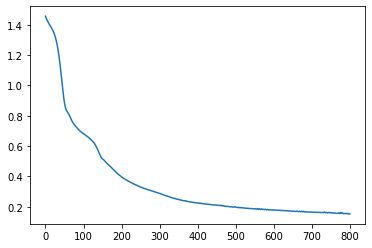

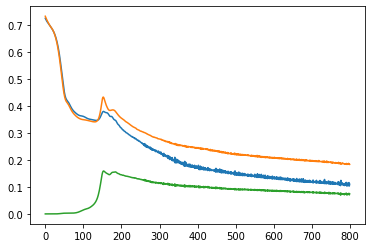

2.0


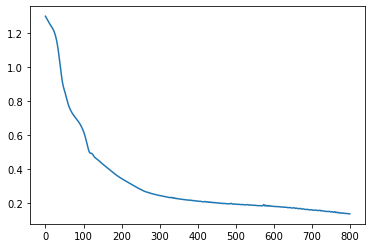

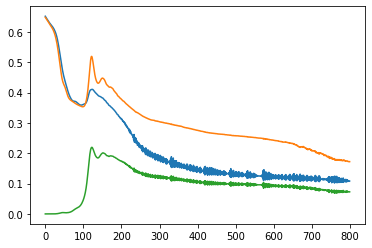

2.1


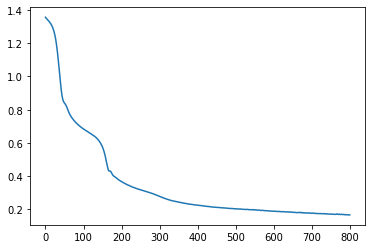

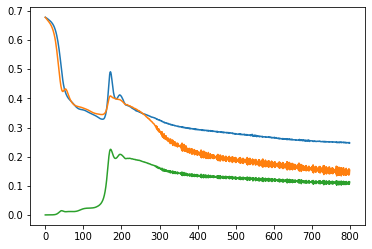

2.2


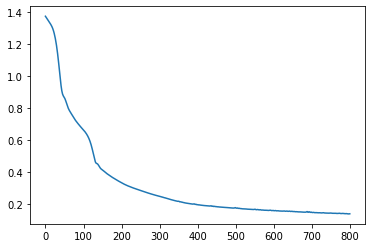

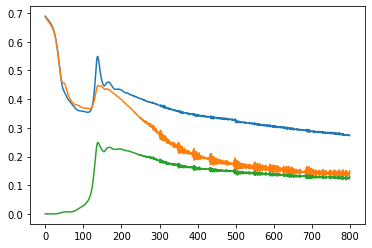

2.3


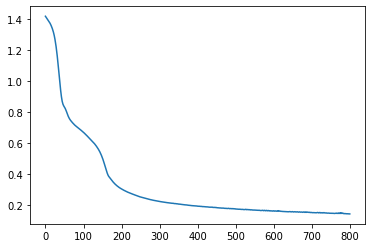

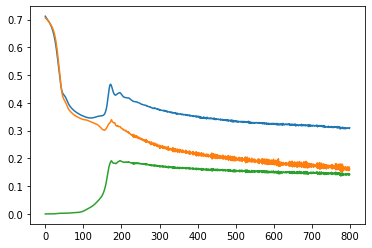

2.4


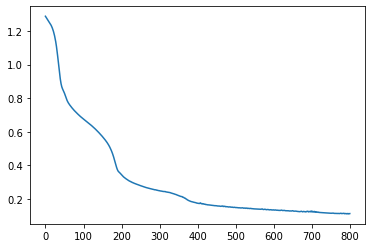

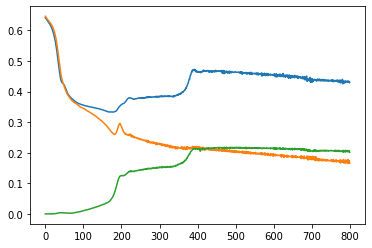

CPU times: user 7min, sys: 41.9 s, total: 7min 42s
Wall time: 7min 10s


In [107]:
%%time

#LAMBDAS = [l/100.0 for l in range(220, 240, 10)] 
LAMBDAS = [l/10.0 for l in range(0, 25, 1)] #ok for N epochs 100
#LAMBDAS = [2.22]
N_EPOCHS = 800

results = {"lambda":[], "acc_f":[], "acc_g":[], "auc_f":[], "auc_g":[], "f1_f":[], "f1_g":[], "disc_score":[]}
iteration, lambdas_ = [], []

data_loader = test_loader
for lambda_ in LAMBDAS:
    print(lambda_)
    for it in range(1):
        disc_model = DiscAdv()
        criterionf = nn.BCELoss(reduction='sum')
        criteriong = nn.BCELoss(reduction='sum')
        criterion_disc = nn.MSELoss(reduction='sum')
        optimizer = optim.Adam(disc_model.parameters(), lr=0.001)
        
        train_discrepancy(lambda_, disc_model, criterionf, criteriong, criterion_disc, optimizer, plot=True)
        accf, accg = accuracy_score2(disc_model, data_loader)
        aucf, aucg = accuracy_AUC2(disc_model, data_loader)
        f1f, f1g = accuracy_f12(disc_model, data_loader)
                
        results["acc_f"].append(accf)
        results["acc_g"].append(accg)
        results["auc_f"].append(aucf)
        results["auc_g"].append(aucg)
        results["f1_f"].append(f1f)
        results["f1_g"].append(f1g)
        results["disc_score"].append(discrepancy(disc_model, data_loader))

        results["lambda"].append(lambda_)
        
df_results = pd.DataFrame.from_dict(results)
df_results["diff_acc"] = (df_results.acc_f - df_results.acc_g).abs()
df_results["diff_auc"] = (df_results.auc_f - df_results.auc_g).abs()
df_results["diff_f1"] = (df_results.f1_f - df_results.f1_g).abs()
df_results["max_acc"] = df_results[["acc_f", "acc_g"]].max(axis=1)
df_results["max_auc"] = df_results[["auc_f", "auc_g"]].max(axis=1)
df_results["max_f1"] = df_results[["f1_f", "f1_g"]].max(axis=1)


In [97]:
import sys; sys.path.insert(0, '../discrepancies-in-machine-learning')
from discrepancies import datasets, pool


pool1 = pool.BasicPool(models=['SVMrbf', 'RF200', 'KNN5'])
print(pool1._model_types)
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
disc_pool = pool1.predict_discrepancies(X_test).mean()
f1_pool = np.array([metrics.f1_score(y_test, preds[c]) for c in preds.columns]).max()
acc_pool = np.array([metrics.accuracy_score(y_test, preds[c]) for c in preds.columns]).max()
diffacc_pool = np.array([metrics.accuracy_score(y_test, preds[c]) for c in preds.columns]).max() - np.array([metrics.accuracy_score(y_test, preds[c]) for c in preds.columns]).min()
difff1_pool = np.array([metrics.f1_score(y_test, preds[c]) for c in preds.columns]).max() - np.array([metrics.f1_score(y_test, preds[c]) for c in preds.columns]).min()
print("accuracy differences", diffacc_pool, difff1_pool)
print("acc best", acc_pool, f1_pool)
print("max theorique", (2 * (1-acc_pool)) + diffacc_pool)
print('disc', disc_pool)



['SVMrbf', 'RF200', 'KNN5']


/Users/b076rg/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/b076rg/Documents/research/articles/discrepancy/discrepancies-generative/../discrepancies-in-machine-learning/discrepancies/pool.py:106: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
/Users/b076rg/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy differences 0.026666666666666616 0.0690851279086575
acc best 0.8377777777777777 0.609625668449198
max theorique 0.35111111111111115
disc 0.07888888888888888


In [101]:
np.array([metrics.accuracy_score(y_test, preds[c]) for c in preds.columns]), np.array([metrics.f1_score(y_test, preds[c]) for c in preds.columns])

(array([0.81444444, 0.83777778, 0.81111111]),
 array([0.54246575, 0.60962567, 0.54054054]))

In [27]:
df_results

,lambda,acc_f,acc_g,auc_f,auc_g,f1_f,f1_g,disc_score,diff_acc,diff_auc,diff_f1,max_acc,max_auc,max_f1
0,2.3,0.916256,0.428571,0.960684,0.934874,0.930041,0.04918,0.596059,0.487685,0.02581,0.880861,0.916256,0.960684,0.930041


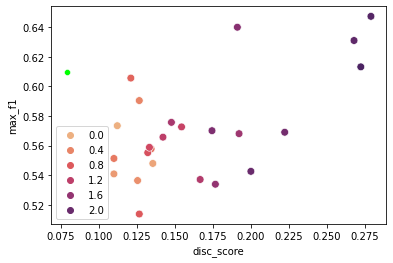

In [108]:


#df_results_probs_halfmoons = df_results_probs.copy()
#df_results_class_halfmoons = df_results_class.copy()
#df_results_probs_boston = df_results.copy()

df_results_temp = df_results[df_results.diff_acc <= 0.05]


#sns.regplot(data=df_results_temp, x="disc_score", y="acc_g", color="brown", order=2)
sns.scatterplot(data=df_results_temp, x="disc_score", y="max_f1", hue="lambda", palette="flare", s=60)
#sns.scatterplot(data=df_results_class, x="disc_score", y="diff_acc", hue="lambda", palette="Blues")
#sns.scatterplot(data=df_results, x="disc_score", y="diff_acc", color="green")
sns.scatterplot(x=[disc_pool], y=[f1_pool], color='lime')
#plt.hlines(y=0.05, xmin=0.0, xmax=1.0, color="red")
#plt.hlines(y=accuracy_score(modelf, test_loader)*1.05, xmin=0.0, xmax=0.22, color="cyan")
#plt.hlines(y=accuracy_score(modelf, test_loader)*0.95, xmin=0.0, xmax=0.22, color="cyan")
#plt.vlines(x=1 - accuracy_score(modelf, test_loader), ymin=0.1, ymax=1.1)

#plt.scatter(x=disc_pool, y=acc_pool, color='lime', s=100)
#plt.ylim((0.4, 1.1))
plt.show()


Boston: un peu chaud à faire bien bien marcher. Paradoxalement, résultats mieux quand N_epochs pas trop grand?...?
En augmantant N_epochs, c'est plus compliqué à faire marcher. 

Tester double BCE Loss

vérifier Adult

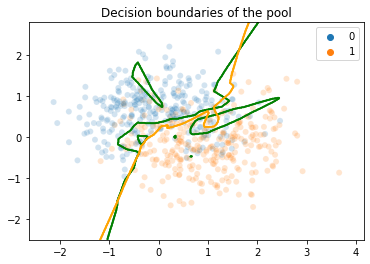

In [176]:
def plot_contour_pool(pool_, data, data_y):
    # Plotting decision regions #bricolage # FOR HALFMOONS
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                      np.arange(y_min, y_max, 0.01))
    colors_ = ['green', 'orange', 'red', 'blue', 'purple', 'yellow', 'pink', 'cyan', 'black', 'grey', 'lime']
    i = 0
    sns.scatterplot(x=data[:,0], y=data[:, 1], hue=data_y.reshape(int(data.shape[0])), alpha=0.2)
    for clf in pool_:
        Z = clf(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
        Z = (Z.detach() >= 0.5).int().numpy().reshape(xx.shape)
        plt.contour(xx, yy, Z, alpha=0.5, colors=colors_[i])
        i += 1
    plt.title('Decision boundaries of the pool')
    plt.show()

def model_f(x):
    f, g = disc_model(x)
    return f

def model_g(x):
    f, g = disc_model(x)
    return g


plot_contour_pool(pool_=[model_f, model_g], data=torch.from_numpy(X_train.values), data_y=y_train)

(tensor([[0.4203],
        [0.0022],
        [0.9231],
        [0.2314],
        [0.5536],
        [0.3950],
        [0.1956],
        [0.7921],
        [0.0093],
        [0.9994],
        [0.0013],
        [0.9868],
        [0.8323],
        [0.9996],
        [0.5340],
        [0.9131],
        [0.2993],
        [0.9923],
        [0.0750],
        [0.7862],
        [0.4176],
        [0.2699],
        [0.9980],
        [0.2950],
        [0.1622],
        [0.8531],
        [0.3363],
        [0.2462],
        [0.3522],
        [0.6205],
        [0.1295],
        [0.9999]], grad_fn=<SigmoidBackward>), tensor([[6.8604e-01],
        [1.9819e-02],
        [9.0068e-01],
        [3.1007e-01],
        [6.1050e-01],
        [5.0654e-01],
        [1.2466e-01],
        [6.7320e-01],
        [1.9568e-02],
        [9.9999e-01],
        [4.1324e-06],
        [9.9908e-01],
        [7.2768e-01],
        [1.0000e+00],
        [4.0698e-01],
        [9.4955e-01],
        [3.3005e-01],
        [9.9989e-01]

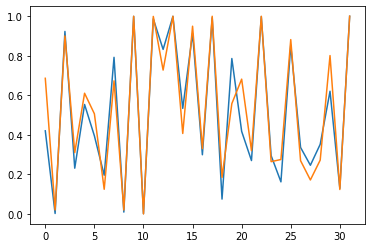

(tensor([[9.9369e-01],
        [9.9487e-01],
        [9.9992e-01],
        [9.5311e-01],
        [8.9463e-01],
        [3.3557e-01],
        [7.8343e-01],
        [3.7691e-01],
        [8.0934e-01],
        [7.3705e-01],
        [1.7268e-02],
        [3.0613e-01],
        [9.9230e-01],
        [9.9997e-01],
        [9.0210e-01],
        [8.1928e-01],
        [9.9701e-01],
        [9.9937e-01],
        [3.3920e-04],
        [5.6649e-04],
        [4.0431e-01],
        [1.8073e-02],
        [9.1968e-01],
        [6.3126e-02],
        [9.5443e-01],
        [9.9079e-01],
        [4.9626e-01],
        [3.4572e-01],
        [2.7633e-02],
        [2.4898e-01],
        [9.3095e-01],
        [1.7395e-02]], grad_fn=<SigmoidBackward>), tensor([[9.9982e-01],
        [9.9898e-01],
        [1.0000e+00],
        [9.8945e-01],
        [8.8015e-01],
        [2.6220e-01],
        [5.8808e-01],
        [2.3144e-01],
        [8.4913e-01],
        [5.6376e-01],
        [2.3172e-04],
        [1.7881e-01],
  

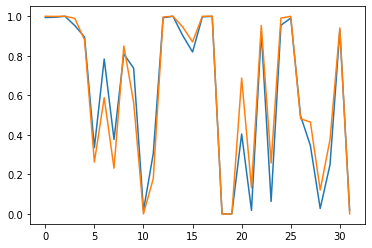

(tensor([[6.0695e-02],
        [2.9044e-01],
        [1.2655e-01],
        [9.9994e-01],
        [7.1715e-01],
        [2.8878e-01],
        [9.9858e-01],
        [8.7605e-02],
        [1.7450e-01],
        [7.5295e-01],
        [9.9140e-01],
        [5.9182e-01],
        [1.7530e-01],
        [8.8331e-01],
        [3.4052e-01],
        [8.5532e-01],
        [9.9996e-01],
        [2.4754e-02],
        [9.8197e-01],
        [9.3131e-06],
        [9.9500e-01],
        [2.5140e-01],
        [2.5054e-01],
        [5.0415e-02],
        [9.1906e-01],
        [8.6565e-01],
        [3.1455e-01],
        [2.6518e-01],
        [2.5157e-01],
        [3.8758e-03],
        [9.9529e-01],
        [8.7534e-01]], grad_fn=<SigmoidBackward>), tensor([[1.8628e-01],
        [2.0700e-01],
        [1.4796e-01],
        [1.0000e+00],
        [5.3457e-01],
        [1.9763e-01],
        [9.9999e-01],
        [2.6935e-01],
        [2.1503e-01],
        [5.9627e-01],
        [9.9991e-01],
        [5.0740e-01],
  

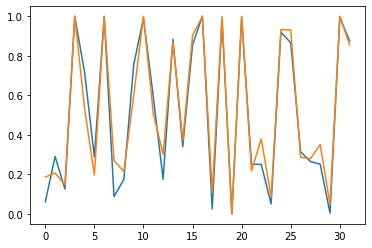

(tensor([[0.9325],
        [0.7123],
        [0.9998],
        [0.1328],
        [0.0601],
        [0.9695],
        [0.9934],
        [0.9862],
        [0.9803],
        [0.9972],
        [0.9176],
        [0.9911],
        [0.2902],
        [0.9997],
        [0.1710],
        [0.2562],
        [0.8332],
        [0.9843],
        [0.0105],
        [0.6616],
        [0.0104],
        [0.6018],
        [0.1880],
        [0.3765],
        [0.0119],
        [0.2885],
        [0.9985],
        [0.9987],
        [0.5877],
        [0.0043],
        [0.9692],
        [0.5910]], grad_fn=<SigmoidBackward>), tensor([[9.3679e-01],
        [5.8935e-01],
        [1.0000e+00],
        [1.8567e-01],
        [1.4825e-01],
        [9.9870e-01],
        [9.9990e-01],
        [9.9944e-01],
        [9.9842e-01],
        [9.9996e-01],
        [9.1710e-01],
        [9.9994e-01],
        [1.9351e-01],
        [1.0000e+00],
        [9.4092e-02],
        [1.2958e-01],
        [8.9734e-01],
        [9.9883e-01]

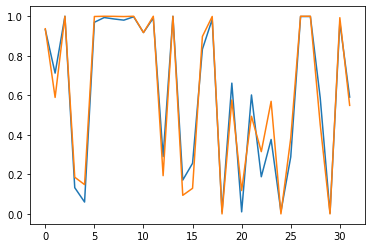

(tensor([[0.2324],
        [0.9836],
        [0.6624],
        [0.0073],
        [0.6293],
        [0.5304],
        [0.0520],
        [0.1638],
        [0.5058],
        [0.0573],
        [0.4015],
        [0.9541],
        [0.0328],
        [0.3619],
        [0.9240],
        [0.9002],
        [0.4652],
        [0.6031],
        [0.9944],
        [0.8222],
        [0.0089],
        [0.8950],
        [0.0399],
        [0.6869],
        [0.9987],
        [0.9895],
        [0.1696],
        [0.0042],
        [0.9442],
        [0.9809],
        [1.0000],
        [0.2929]], grad_fn=<SigmoidBackward>), tensor([[3.6486e-01],
        [9.9881e-01],
        [8.0767e-01],
        [2.5072e-05],
        [4.7860e-01],
        [7.6336e-01],
        [1.2434e-01],
        [1.5915e-01],
        [7.2852e-01],
        [1.1847e-01],
        [4.8377e-01],
        [9.9695e-01],
        [1.3916e-03],
        [5.4996e-01],
        [9.8186e-01],
        [8.8087e-01],
        [6.6316e-01],
        [6.4549e-01]

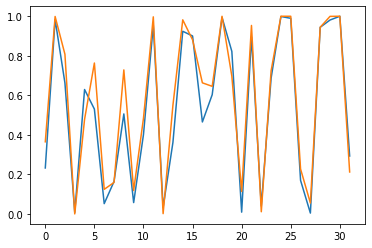

(tensor([[9.2751e-01],
        [1.3934e-03],
        [9.5891e-01],
        [9.9108e-01],
        [1.6918e-04],
        [9.7629e-01],
        [6.3765e-01],
        [2.0911e-01],
        [1.7730e-01],
        [1.7570e-02],
        [2.7482e-01],
        [4.4400e-01],
        [2.0133e-01],
        [8.8258e-01],
        [1.0145e-02],
        [1.3009e-01],
        [6.2266e-01],
        [1.8207e-02],
        [8.9032e-02],
        [9.8130e-01],
        [9.9996e-01],
        [9.4878e-01],
        [1.3284e-01],
        [6.7111e-01],
        [7.2027e-01],
        [1.5955e-03],
        [3.4998e-03],
        [8.5504e-01],
        [2.5783e-02],
        [1.7579e-01],
        [9.9097e-01],
        [3.0838e-01]], grad_fn=<SigmoidBackward>), tensor([[9.7494e-01],
        [2.4083e-06],
        [9.9742e-01],
        [9.9943e-01],
        [5.0322e-09],
        [9.9764e-01],
        [6.0189e-01],
        [2.5312e-01],
        [2.4361e-01],
        [1.2750e-01],
        [1.5727e-01],
        [5.2173e-01],
  

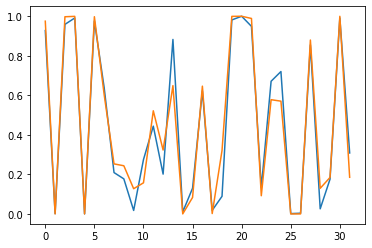

(tensor([[0.4275],
        [0.5580],
        [0.6780],
        [0.6799],
        [0.0614],
        [1.0000],
        [0.0529],
        [0.0219],
        [0.8246],
        [0.9490],
        [0.0228],
        [0.9937],
        [0.3078],
        [0.9996],
        [0.0097],
        [0.4929],
        [0.0842],
        [0.6603],
        [0.7532],
        [0.0014],
        [0.9821],
        [0.0934],
        [0.0771],
        [0.3852],
        [0.6569],
        [0.0221],
        [0.7006],
        [0.9443],
        [0.6503],
        [0.4043],
        [0.9903],
        [0.9981]], grad_fn=<SigmoidBackward>), tensor([[6.5222e-01],
        [4.0995e-01],
        [6.5589e-01],
        [8.0852e-01],
        [2.0243e-01],
        [1.0000e+00],
        [1.6383e-01],
        [1.2236e-01],
        [8.2955e-01],
        [9.7766e-01],
        [5.4958e-04],
        [9.9975e-01],
        [1.7844e-01],
        [9.9998e-01],
        [1.2643e-04],
        [6.4745e-01],
        [2.0320e-01],
        [5.0971e-01]

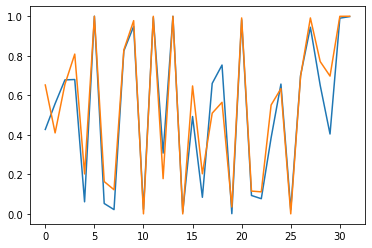

(tensor([[2.9387e-04],
        [1.8895e-01],
        [9.1863e-03],
        [3.1298e-01],
        [9.2753e-02],
        [8.2486e-01],
        [9.9638e-01],
        [1.1140e-02],
        [3.2848e-02],
        [7.4052e-01],
        [7.0380e-01],
        [5.0082e-01],
        [2.0498e-02],
        [8.8833e-01],
        [9.7970e-01],
        [8.5594e-01],
        [4.7051e-02],
        [5.1401e-02],
        [7.7405e-01],
        [9.9661e-01],
        [9.0941e-01],
        [3.0321e-01],
        [4.7639e-01],
        [9.9578e-01],
        [7.3182e-01],
        [1.3118e-03],
        [3.2622e-01],
        [9.9975e-01],
        [1.8134e-01],
        [2.5743e-03],
        [9.8292e-01],
        [5.5158e-03]], grad_fn=<SigmoidBackward>), tensor([[2.3215e-08],
        [1.7058e-01],
        [4.0434e-05],
        [2.6848e-01],
        [2.0328e-01],
        [7.9827e-01],
        [9.9996e-01],
        [1.2065e-01],
        [6.8513e-02],
        [7.6192e-01],
        [5.1756e-01],
        [5.0471e-01],
  

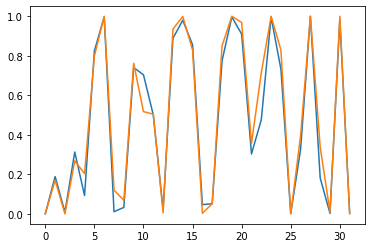

(tensor([[0.5239],
        [0.8659],
        [0.8190],
        [0.9773],
        [0.2548],
        [0.4470],
        [0.9757],
        [0.0237],
        [0.6373],
        [0.9457],
        [0.1502],
        [0.6003],
        [0.9784],
        [0.3346],
        [0.9741],
        [0.6061],
        [1.0000],
        [0.8647],
        [0.9183],
        [0.1841],
        [0.0313],
        [0.9563],
        [0.2685],
        [0.9994],
        [0.0803],
        [0.6993],
        [0.9894],
        [0.3041],
        [0.2663],
        [0.3782],
        [0.3026],
        [0.5201]], grad_fn=<SigmoidBackward>), tensor([[0.5198],
        [0.7162],
        [0.9562],
        [0.9924],
        [0.1637],
        [0.5263],
        [0.9975],
        [0.1282],
        [0.5832],
        [0.9493],
        [0.1455],
        [0.7268],
        [0.9994],
        [0.2627],
        [0.9973],
        [0.6219],
        [1.0000],
        [0.8850],
        [0.9884],
        [0.0794],
        [0.0535],
        [0.9955]

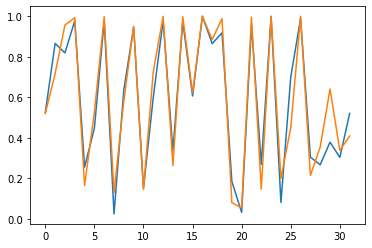

(tensor([[0.0313],
        [0.4033],
        [0.0937],
        [0.3060],
        [0.5802],
        [0.9766],
        [0.2031],
        [0.9922],
        [0.9694],
        [0.9940],
        [0.5109],
        [0.8137],
        [0.0013],
        [0.0102],
        [0.9996],
        [0.2424],
        [0.0046],
        [0.1302],
        [0.9811],
        [0.2775],
        [0.1904],
        [0.1431],
        [0.9996],
        [0.6793],
        [0.7338],
        [0.2121],
        [0.9750],
        [0.6622],
        [0.9864],
        [0.0108],
        [0.3831],
        [0.6897]], grad_fn=<SigmoidBackward>), tensor([[2.4928e-02],
        [6.2531e-01],
        [2.1522e-01],
        [3.2414e-01],
        [4.1884e-01],
        [9.9768e-01],
        [2.6598e-01],
        [9.9987e-01],
        [9.9230e-01],
        [9.9973e-01],
        [7.3016e-01],
        [8.8214e-01],
        [3.8372e-03],
        [1.8310e-04],
        [1.0000e+00],
        [3.6382e-01],
        [1.0000e-05],
        [1.1143e-01]

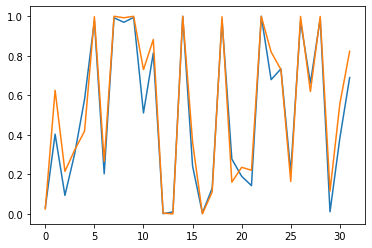

(tensor([[5.7323e-01],
        [6.3683e-01],
        [5.5565e-01],
        [6.3258e-01],
        [9.5160e-01],
        [2.5939e-01],
        [2.2224e-01],
        [3.3678e-01],
        [9.0754e-01],
        [8.1849e-01],
        [8.8046e-01],
        [4.5960e-01],
        [1.3118e-01],
        [4.2427e-04],
        [2.0106e-01],
        [7.0837e-01],
        [2.6630e-01],
        [2.6937e-01],
        [2.8527e-01],
        [7.6840e-01],
        [9.8101e-01],
        [9.9942e-01],
        [6.1278e-01],
        [6.2878e-02],
        [1.3774e-01],
        [3.7985e-01],
        [9.9991e-01],
        [1.2437e-01],
        [9.1287e-01],
        [1.1472e-01],
        [9.9916e-01],
        [9.7833e-01]], grad_fn=<SigmoidBackward>), tensor([[4.4195e-01],
        [7.7739e-01],
        [4.8138e-01],
        [7.8814e-01],
        [9.8905e-01],
        [2.8140e-01],
        [3.6276e-01],
        [3.7694e-01],
        [9.4317e-01],
        [8.5485e-01],
        [8.7823e-01],
        [3.9368e-01],
  

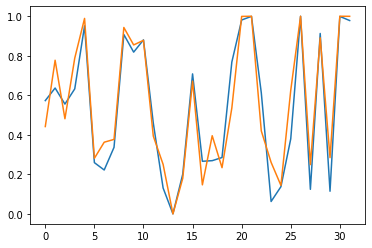

(tensor([[0.3125],
        [0.1964],
        [0.6558],
        [0.7528],
        [0.0768],
        [0.0045],
        [0.8431],
        [0.1975],
        [0.7114],
        [0.9850],
        [0.0274],
        [0.0898],
        [0.9636],
        [0.7478],
        [0.2825],
        [0.7792],
        [0.0165],
        [0.6725],
        [0.0352],
        [0.8241],
        [0.3110],
        [0.4317],
        [0.1739],
        [0.0496],
        [0.0069],
        [0.9371],
        [0.0011],
        [0.4292],
        [0.9991],
        [0.9481],
        [0.1840],
        [0.0518]], grad_fn=<SigmoidBackward>), tensor([[2.4149e-01],
        [3.7515e-01],
        [7.7043e-01],
        [8.1356e-01],
        [2.4915e-01],
        [8.3192e-06],
        [7.2577e-01],
        [1.1784e-01],
        [5.7385e-01],
        [9.9969e-01],
        [2.3665e-02],
        [2.6273e-01],
        [9.9717e-01],
        [6.3500e-01],
        [2.5196e-01],
        [6.2659e-01],
        [8.8085e-02],
        [4.7428e-01]

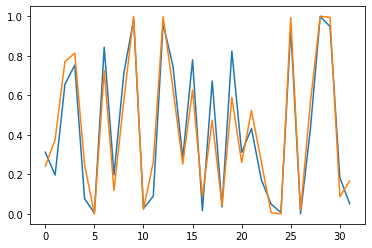

(tensor([[0.9350],
        [0.9995],
        [0.9443],
        [0.0140],
        [0.9183],
        [0.2532],
        [0.4592],
        [0.3140],
        [0.8089],
        [0.1132],
        [0.7942],
        [0.9164],
        [0.8070],
        [0.6636],
        [0.5315],
        [0.0703]], grad_fn=<SigmoidBackward>), tensor([[0.7405],
        [1.0000],
        [0.9722],
        [0.0455],
        [0.7815],
        [0.2762],
        [0.6984],
        [0.3182],
        [0.8208],
        [0.1361],
        [0.8658],
        [0.9732],
        [0.7929],
        [0.5766],
        [0.4247],
        [0.1774]], grad_fn=<SigmoidBackward>))


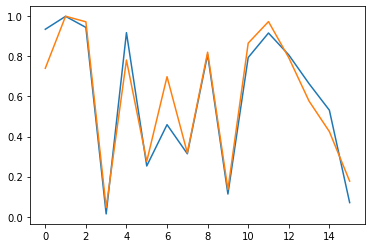